# Scater: quality control and filtering

In [10]:
suppressPackageStartupMessages({
    library(DropletUtils)
    library(SingleCellExperiment)
    library(scuttle)
    library(Seurat)
    library(SeuratWrappers)
    library(stringr)
    library(dplyr)
    library(data.table)
    library(Matrix)
    library(patchwork)
    library(ggplot2)
})

options(repr.plot.width = 16, repr.plot.height = 8)

## Getting limb subset

In [40]:
sce.data <- Read10X(
    data.dir="./sham_d7/",
    unique.features = TRUE,
    strip.suffix = FALSE)
sce_seurat <- CreateSeuratObject(counts = sce.data)

In [41]:
sce <- as.SingleCellExperiment(sce_seurat)

### Inspect the metadata

In [42]:
head(colData(sce))

DataFrame with 6 rows and 4 columns
                      orig.ident nCount_RNA nFeature_RNA         ident
                        <factor>  <numeric>    <integer>      <factor>
AAACCCAGTATACAGA-1 SeuratProject       9480         2664 SeuratProject
AAACCCATCAACCTCC-1 SeuratProject      10360         2262 SeuratProject
AAACGAACACCCTGAG-1 SeuratProject       8352         3001 SeuratProject
AAACGAACACCGAATT-1 SeuratProject       5743         2102 SeuratProject
AAACGCTGTCGAGATG-1 SeuratProject       7091         2237 SeuratProject
AAAGAACAGATGGGCT-1 SeuratProject      10593         2675 SeuratProject

Dimensions of the raw data are **55.418 genes and 192 cells**.

## Calculating QC metrics

First we identify rows corresponding to mitochondrial genes, which can be found based on the rownames.

In [43]:
is.mito <- grepl("^mt-", rownames(sce))
mito.list <-  grep("^mt-", rownames(sce), value = TRUE)

For each cell we calculate quality control metrics such as the total number of counts or the proportion of counts in mitochondrial genes.

In [44]:
is.spike <- grepl("^gSpikein", rownames(sce))
spike.list <- grep("^gSpikein", rownames(sce), value = TRUE)

In [45]:
celldata <- perCellQCMetrics(sce, subsets = list(Mt = is.mito, ERCC = is.spike))

In [46]:
sce <- addPerCellQC(sce, subsets=list(Mito = is.mito, ERCC = is.spike))
colnames(colData(sce))

[1] "orig.ident"            "nCount_RNA"            "nFeature_RNA"         
 [4] "ident"                 "sum"                   "detected"             
 [7] "subsets_Mito_sum"      "subsets_Mito_detected" "subsets_Mito_percent" 
[10] "subsets_ERCC_sum"      "subsets_ERCC_detected" "subsets_ERCC_percent" 
[13] "total"

In [47]:
sce

class: SingleCellExperiment 
dim: 32285 2097 
metadata(0):
assays(2): counts logcounts
rownames(32285): Xkr4 Gm1992 ... AC234645.1 AC149090.1
rowData names(0):
colnames(2097): AAACCCAGTATACAGA-1 AAACCCATCAACCTCC-1 ...
  TTTGTTGAGGGTATAT-1 TTTGTTGCATTCAGGT-1
colData names(13): orig.ident nCount_RNA ... subsets_ERCC_percent total
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

### QC of the cells

Low-quality cells need to be removed to ensure that technical effects do not distort downstream analysis
results. Two common measures of cell quality are the library size and the number of expressed features in
each library. The library size is defined as the total sum of counts across all features, i.e. genes. Cells with
relatively small library sizes are considered to be of low quality as the RNA has not been efficiently captured
(i.e. converted into cDNA and amplified) during library preparation. The number of expressed features in
each cell is defined as the number of features with non-zero counts for that cell. Any cell with very few
expressed genes is likely to be of poor quality as the diverse transcript population has not been successfully
captured. The distribution of both of these metrics can be seen in the histograms below.

In [48]:
sce$sum

[1]  9480 10360  8352  5743  7091 10593  1109  4649  9393  3538 13266  6603
  [13]   664   796  9913   970  8135  3637  2596  8691 41715 27133   544  9606
  [25]  5386 15031   726  9164  7058 10090 13865 10650  3866  6398  7437  7286
  [37] 15014  4119  1436   732  8430  7425 11841  9615  6372  9738 16267   825
  [49]  5295 10298  6653  7880 10438  4761  6077  1521  5408  3457  1282  7090
  [61] 10004 12087   563 13657  7829  5324 12158  6920  5064  2548 12010  2836
  [73]  5270  4453  2346 13333  1039  6590 13416  8324  3205  5922  8193  3378
  [85] 13770 10058  8805  3909  9349  5853  5338  9398 12236   999  2347  4674
  [97]  1267 13948  4289  1039  2265  9906 16536  7839 10190  7001  9700   731
 [109]   584 11478  3658  5487   611  6086   706  2589   956   976  6036  6271
 [121]  3930 11426  2110  9991 11937   756  7711  4190 11920  4562  6075 13281
 [133]  5424  2618  5010  6707   660 15649   751  6148  2870 25183 10278   650
 [145] 10966  1255  1102   776  8368 11549 10449 14130 11507  2133 15957   586
 [157]   510  1449  4018 10456  9790  5414  1196 10572   782  3187  8780  7696
 [169]   500  7311  9446  2190  3758 10835  4695  8842  5651   948  9221  3079
 [181]  5620  1398 11861 12602  1100  8649  8968   636   514  3600  1824 14757
 [193]  2323  5043  2337  5783 11500  6338  3663  8006  4743  7389  3322   611
 [205]  7304   912   646  3904   658 12259  1095 14663  1587   940  2900  5224
 [217]   980  6885  8584 10369  4560  2940  2737   542  1776  6102  3920   520
 [229]  9729 15882 16930 13347  3450  3880   568  1549  7069  2611 10719 10748
 [241]  6388  1119  3171  3432  6557 16023  5286  5647  3651   805 18745   660
 [253] 11583 37802  9236 14698  6482  9338  5942  3414  4646  3558  3775  2296
 [265]  2372 19991   703   512   597  9436 12551 23123 10440   871  8512  8698
 [277]  5232  6538  2905 15220   592  7678   534  2196  1076  8780  5197  1507
 [289]   512  3385  5643  5823 12872  4541 30410  1996 16003   563  4483  4584
 [301] 12258 11583   527  2627   842  1344  1889  3803 14332  5688  4440   719
 [313]  7637  6557 11067 12553   518  7718  8880   681  5529  5198  4063  4119
 [325]  5764 15415  3483 13144  7851  1640  8359  1558  6140  2204  6201  3000
 [337]  4219 12043  6978  7546  5107 10108 14722   602  1736  8394  3709  3650
 [349]  3872 14113  9147  3873  1283  2804  9799  8572  1494   523   832   594
 [361]  3482  6143  9975  5800  1774   916  5166   509  8413  9915 11054   762
 [373]   817  4830   694   561  7997  3792   505   505 13947   576 25988 13474
 [385]  3584  8817  2517  8492  7121  6314 13837  8002  1568   535  6211  9457
 [397]  8439  3144   813 11104   609  7343   667 11850 10668 30793  3313  6336
 [409]  6839  5279  5608 11017  1713  9031  3791  1148  8504   650  3056  6803
 [421]  9001 12580  8243  4352 13287  6935  2481  7540  6541 11547  8322  2092
 [433] 21161  4999  6328   605 10272  4347  2774   952  2503  5991  4960  2748
 [445]  9705  5190  4561  4514  3581  5714  1721  9644  3806  1649  6395  6093
 [457]  2834  8119  1966   509  7692 11048  7022 10100  5483 10448  6102  8292
 [469]  3715  8293 10910  3206 11124  7280  4328  7708  8848  9274   728  6578
 [481]  4469  5414  2409   541  3216  6902   540  5133  7215  2287  1235 15255
 [493] 10167 10497  3469  7156  4184  2363  8398 12139  7144  2394  8330   868
 [505] 12650  7694  2500  1074  3070 11017  8575   526  3497 10142  4598  8550
 [517]  6911 13488 12813  4273   829  2533  3152  8773  8486  3003  3753  7132
 [529]  5820   905   964  3769   734 15367 11797  9853  5186   605 10091  3694
 [541]  9787  6970  1466  2847   558  8969  4251  5398  1036 14667   509  7129
 [553] 13203  2365  2405 11786   814   601  9906  1412  8174   527  4452  5428
 [565]  2475  8882  1021  4845  9449  9248 22008  6352  2732  9515  3564  4821
 [577] 61006   961  1065  9219  2408 38707  6455  7443  8399 13479  1784 20011
 [589] 12889  8733 10537  4924 13614  4450 10503  2130 14279  1673  2187  1885
 [601]  7245   552   940  4370  4540   633 10283 1030

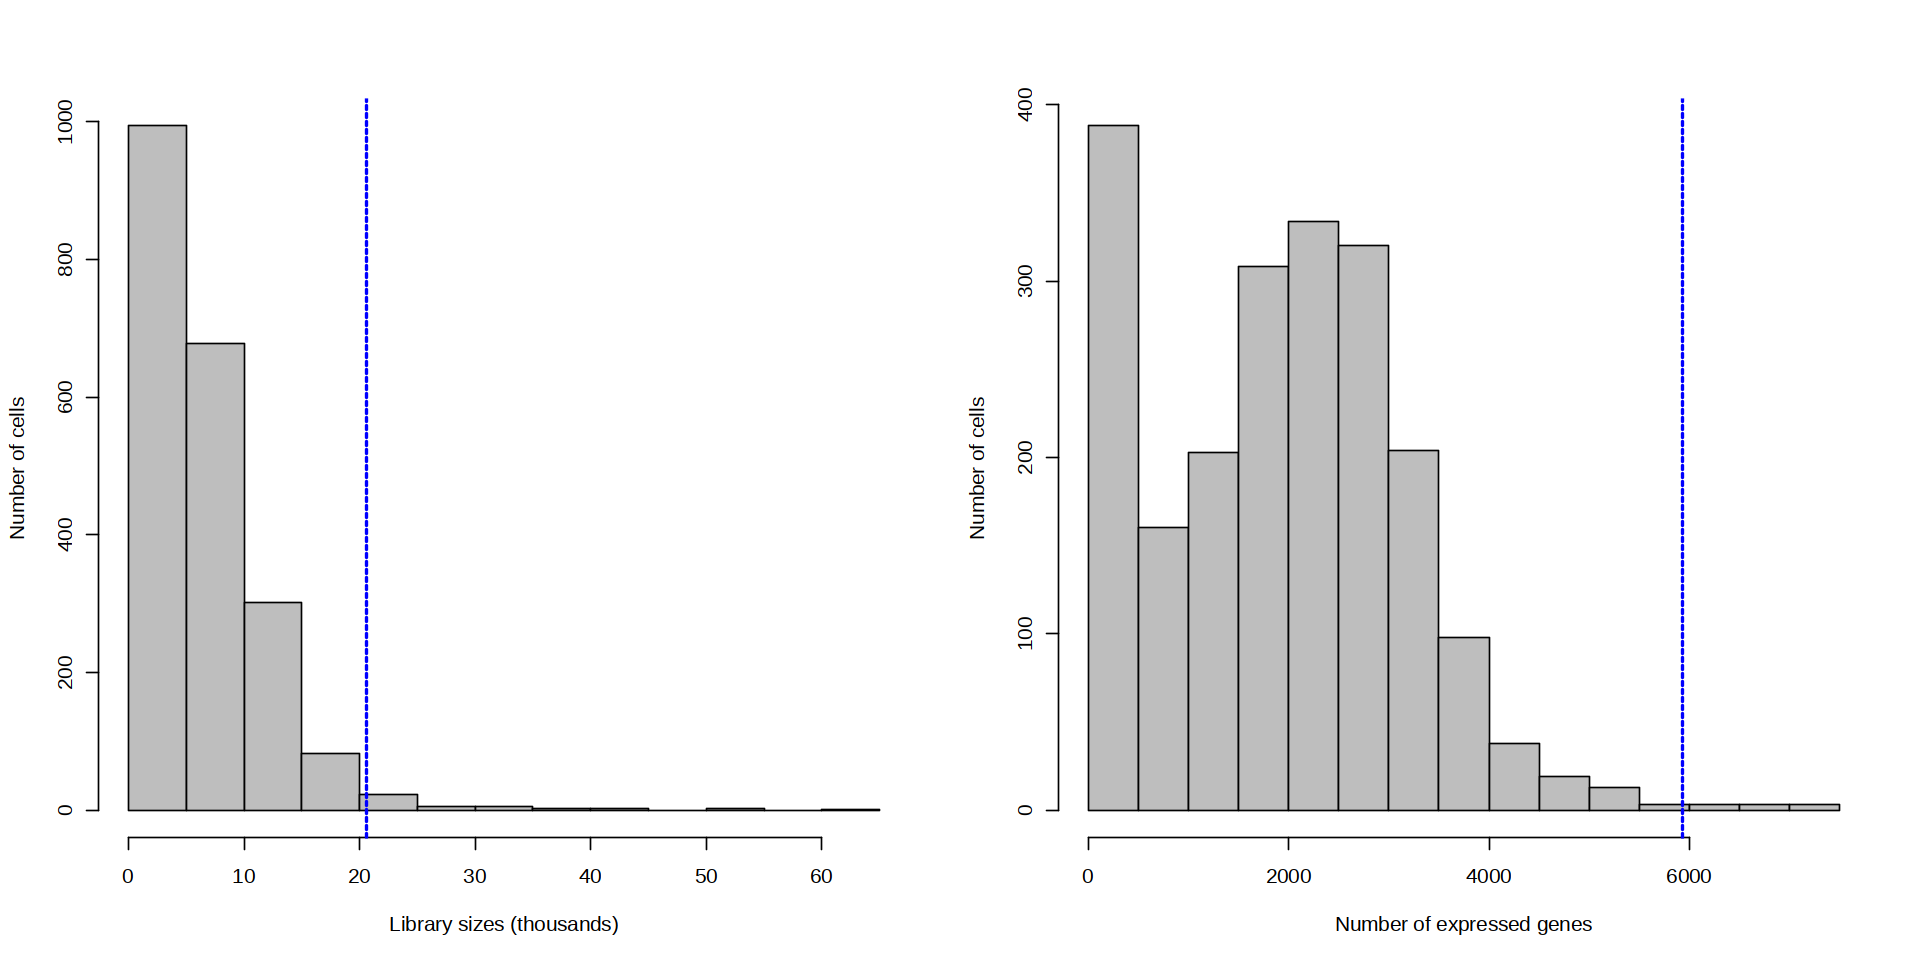

In [49]:
libsize.drop <- isOutlier(sce$sum, nmads = 3, type = "both", log = TRUE)
feature.drop <- isOutlier(sce$detected, nmads = 3, type = "both", log = TRUE)

# libsize.drop cutoff values
min.libsize <- (median(sce$sum) - 3*mad(sce$sum))/1e3
max.libsize <- (median(sce$sum) + 3*mad(sce$sum))/1e3

# feature.drop cutoff values
min.features <- (median(sce$detected) - 3*mad(sce$detected))
max.features <- (median(sce$detected) + 3*mad(sce$detected))

par(mfrow = c(1,2))

hist(sce$sum/1e3, xlab = "Library sizes (thousands)", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

abline(v = min.libsize, col = "blue", lwd = 2, lty = 2)
abline(v = max.libsize, col = "blue", lwd = 2, lty = 2)

hist(sce$detected, xlab = "Number of expressed genes", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

abline(v = min.features, col = "blue", lwd = 2, lty = 2)
abline(v = max.features, col = "blue", lwd = 2, lty = 2)

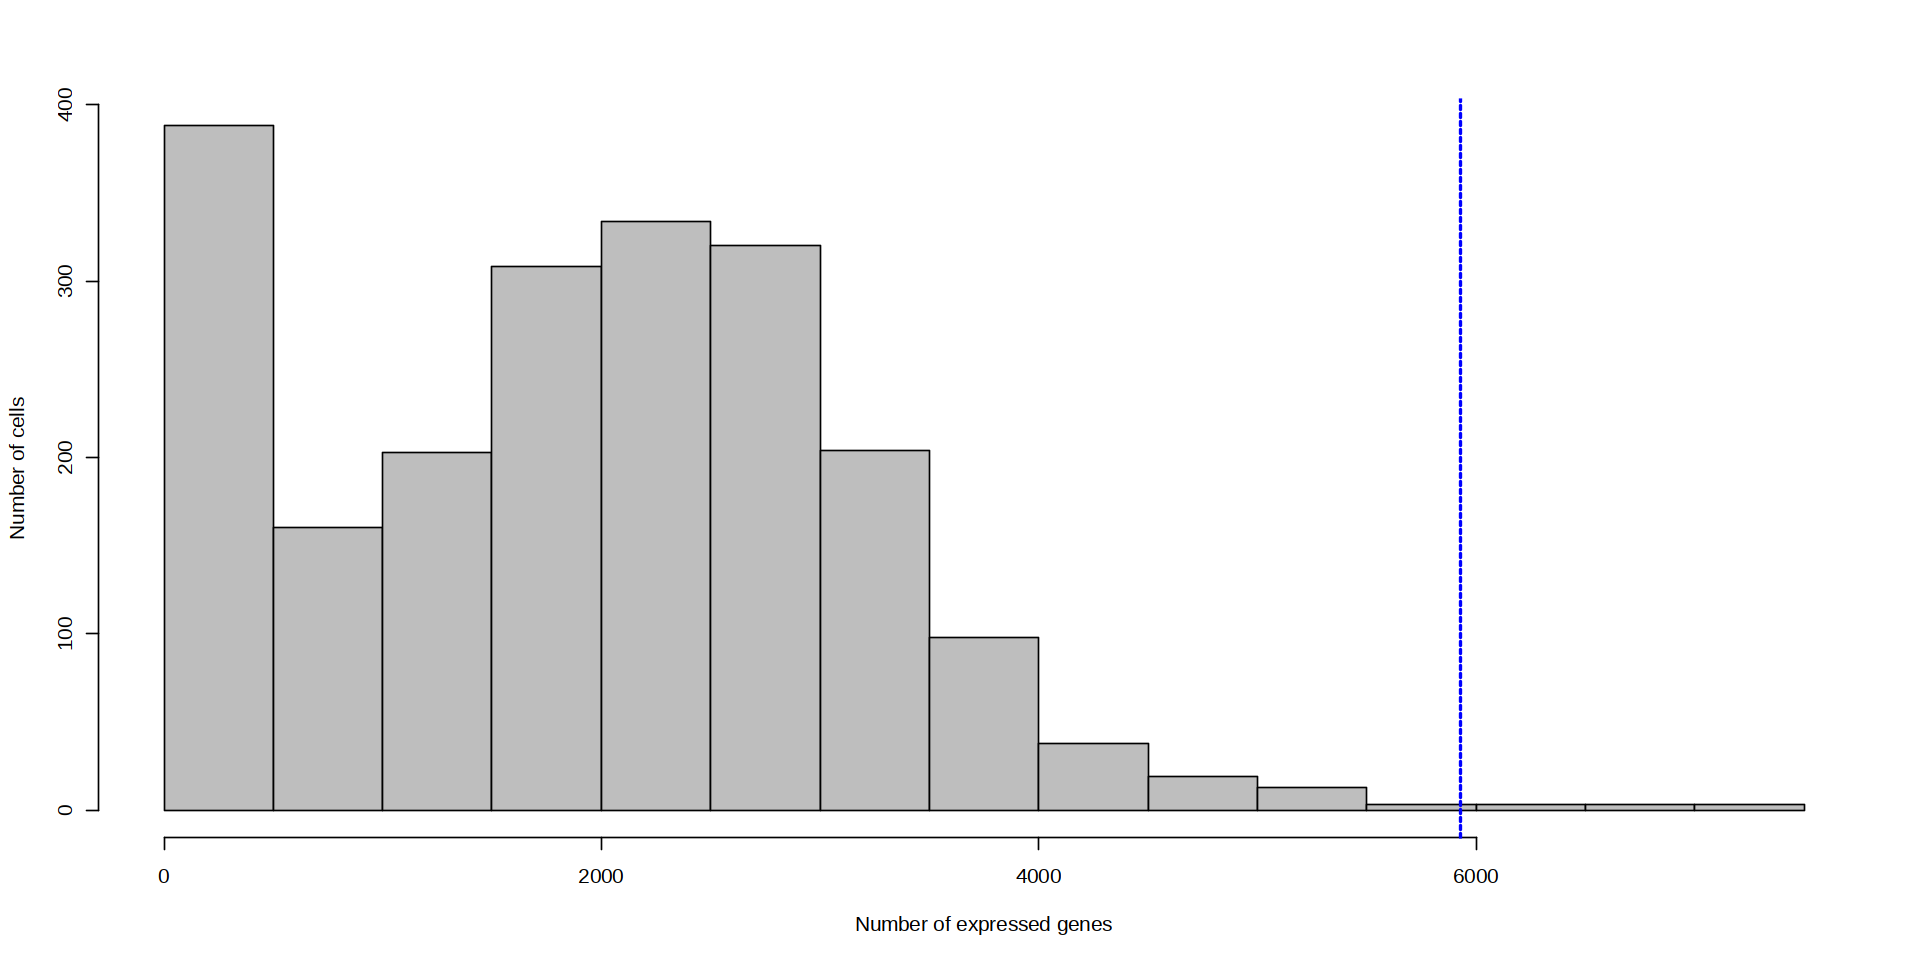

In [50]:
hist(sce$detected, xlab = "Number of expressed genes", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")
abline(v = min.features, col = "blue", lwd = 2, lty = 2)
abline(v = max.features, col = "blue", lwd = 2, lty = 2)

Selecting a threshold for these metrics is not straightforward as their absolute values depend on the protocol
and the biological system. For example, sequencing to greater depth will lead to more reads, regardless of
the quality of the cells. To obtain an adaptive threshold, we assume that most of the dataset consists of
high-quality cells. We remove cells with log-library sizes that deviate more than 3 absolute deviations from
the median (Lun et al. 2016, Davie et al., 2018). The log transformation is performed to improve resolution
at small values, which is especially necessary when the absolute deviation of the raw values is comparable to
or greater than the median.
Note: Davie et al. only flag a cell as an outlier when its 5 absolute deviations from the median.

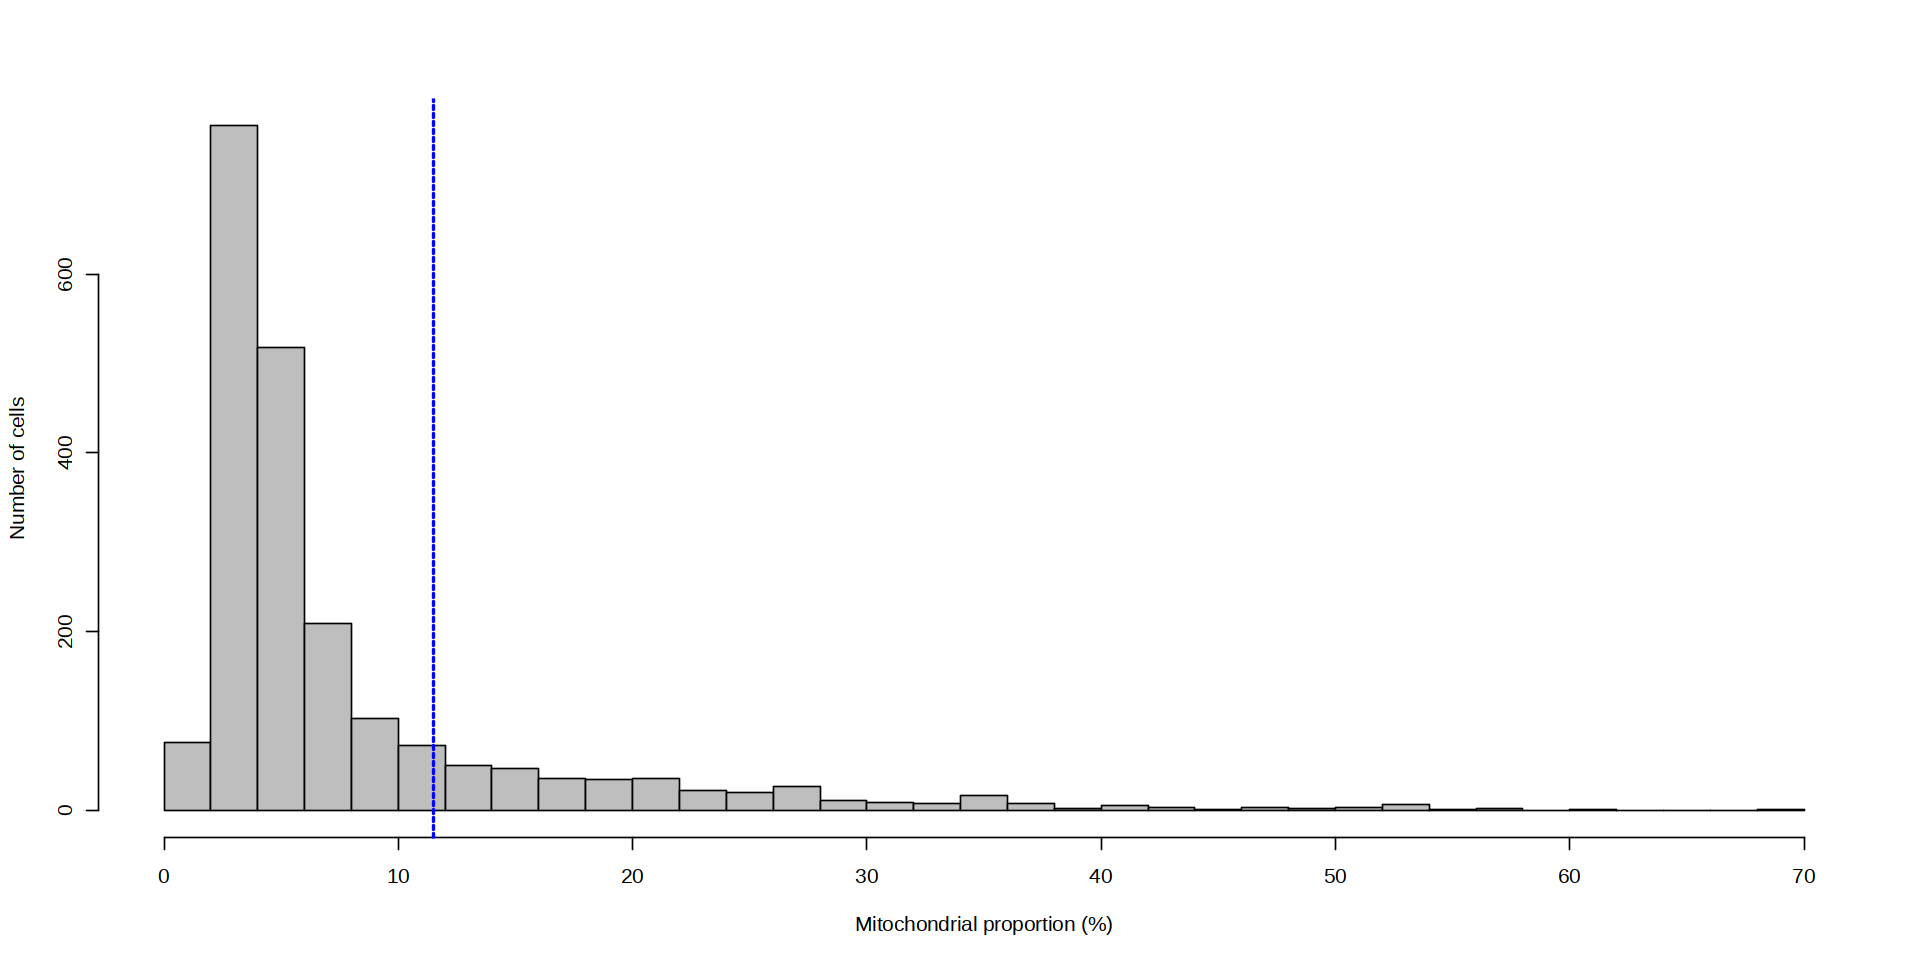

In [51]:
mito.drop <- isOutlier(sce$subsets_Mito_percent, nmads = 3)

max.mito <- median(sce$subsets_Mito_percent) + 3*mad(sce$subsets_Mito_percent)

hist(sce$subsets_Mito_percent, xlab = "Mitochondrial proportion (%)",
     ylab = "Number of cells",
     breaks = 40, main = "", col = "grey")

abline(v = max.mito, col = "blue", lwd = 2, lty = 2)

In [52]:
sceQC <- sce[,!(libsize.drop | feature.drop | mito.drop)]
data.frame(ByLibrarySize = sum(libsize.drop), ByFeature = sum(feature.drop), ByMito = sum(mito.drop),
           Remaining = ncol(sceQC))

ByLibrarySize,ByFeature,ByMito,Remaining
<int>,<int>,<int>,<int>
0,211,369,1663


In [53]:
average.counts <- calculateAverage(sceQC, exprs_values = "counts",
                                   subset_row = NULL)
genes.to.keep <- average.counts >= 0.001
sum(genes.to.keep)

[1] 16816

Another measure of quality is the proportion of reads mapped to genes in the mitochondrial genome. High
proportions are indicative of poor quality cells (Ilicic et al., 2016), possibly because of increased apoptosis
and/or loss of cytoplasmic RNA from lysed cells. In addition, a high proportion of mitochondrial reads could
reflect an inefficient capture of the RNA when creating the library.
By assuming most cells in the dataset are of high quality, the threshold to remove cells with too high
mitochondrial proportions can be set to remove any large outliers. For this, the median absolute deviation
method is used again.

In [54]:
sce <- sceQC[genes.to.keep,]
dim(sce)

[1] 16816  1663

In [55]:
sce <- sce[!duplicated(rownames(sce)),]
dim(sce)

[1] 16816  1663

In [56]:
sce <- as.Seurat(sce)

In [57]:
saveRDS(sce, file = "Maerz_shamd7_QCfiltered.Rds")